In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from sklearn.linear_model import LinearRegression

%load_ext lab_black
%load_ext watermark

# A Simple Regression

Adapted from [unit 1: Regression.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit1/Regression.odc) and [unit 1: Regression.m](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit1/Regression.m).

Associated lecture video: Unit 1 Lesson 4.

## Initial values

The professor often sets the initial values manually in BUGS because the generated initial values can be really crazy if you use wide priors.

Setting inits manually is not necessary in PyMC. The generated values are probably always going to be better than what you would have chosen. If a model is not running in PyMC and you suspect it is because of the initial values, instead of manually entering new ones select one of the [many other methods](https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.init_nuts.html) for generating them by using the ```init``` parameter of ```pm.sample```. I've found the new ```"jitter+adapt_diag_grad"``` option really helpful here for certain models.

If you really do want to set initial values, pass a dictionary with the keys as variable names to the ```initvals``` parameter of ```pm.sample```, like this:

```python
inits = {
    "alpha": np.array(0.0),
    "beta": np.array(0.0)
}

trace = pm.sample(2000, initvals=inits)
```


In [2]:
# data
X = np.array([1, 2, 3, 4, 5])
y = np.array([1, 3, 3, 3, 5])
x_bar = np.mean(X)

with pm.Model() as m:  # context manager with pm.Model class
    # priors
    alpha = pm.Normal("alpha", sigma=100)
    beta = pm.Normal("beta", sigma=100)
    # using precision for direct comparison with BUGS output
    tau = pm.Gamma("tau", alpha=0.001, beta=0.001)

    mu = alpha + beta * (X - x_bar)

    # likelihood uses observed parameter to incorporate target data
    # the Normal dist can be specified with tau instead of sigma
    pm.Normal("likelihood", mu=mu, tau=tau, observed=y)

    # start sampling and save results to trace variable
    trace = pm.sample(
        draws=3000,
        chains=4,  # independent runs of the sampling process
        tune=500,
        init="jitter+adapt_diag",
        random_seed=1,
        cores=4,  # parallel processing of chains
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, tau]


Sampling 4 chains for 500 tune and 3_000 draw iterations (2_000 + 12_000 draws total) took 8 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6604, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9076, but should be close to 0.8. Try to increase the number of tuning steps.


## Visualize your model structure

PyMC has a built-in method to visualize the structure of your model. It's really useful for making sure your code is doing what you intended.

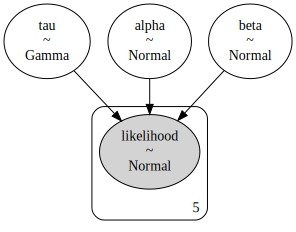

In [3]:
pm.model_to_graphviz(model=m)

## Tuning and burning samples

PyMC uses the tuning step specified in the pm.sample call to adjust various parameters in the No-U-Turn Sampler [(NUTS) algorithm](https://arxiv.org/abs/1111.4246), which is a form of Hamiltonian Monte Carlo. BUGS also silently uses different types of tuning depending on the algorithm it [chooses](https://www.york.ac.uk/depts/maths/histstat/pml1/bayes/winbugsinfo/cowles_winbugs.pdf). The professor also usually burns some number of samples in his examples. Note that this is separate from the tuning phase for both programs! 

We will not require students to burn PyMC samples separately from the tuning phase. So if a homework or exam problem specifies that you must burn 1000 samples, you can just set ```tune=1000``` in your ```pm.sample``` call and be done with it. That said, if for some reason you needed to burn samples from a PyMC trace after sampling, you could slice the trace (which is based on [xarray](https://docs.xarray.dev/en/stable/index.html)) like so:

In [4]:
# this burns the first 500 samples
trace_burned = trace.sel(draw=slice(500, None))

For some more detail on tuning, see [this post](https://colcarroll.github.io/hmc_tuning_talk/).

## ArViz for visualization and summary statistics

For visualization and summarization of your trace, use [ArViz](https://arviz-devs.github.io/arviz/).

Arviz has a variety of functions to view the results of the model. One of the most useful is ```az.summary```. Professor Vidakovic arbitrarily asks for the 95% credible set (also called the highest density interval), so we can specify hdi_prob=.95 to get that. This is the HPD, or minimum-width, credible set.

In [5]:
az.summary(trace_burned, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.999,0.537,2.069,4.047,0.009,0.006,4703.0,3016.0,1.00
beta,0.800,0.362,0.045,1.454,0.005,0.005,5153.0,3907.0,1.00
tau,1.970,1.591,0.006,5.270,0.032,0.023,2051.0,2893.0,1.01


You can also get the HDI directly:

In [6]:
az.hdi(trace_burned, hdi_prob=0.95)["beta"].values

array([0.04543128, 1.45407647])

There are a variety of plots available. Commonly used to diagnose problems are the trace (see [When Traceplots go Bad](https://jpreszler.rbind.io/post/2019-09-28-bad-traceplots/)) and rank plots (see "Maybe it's time to let traceplots die" from [this post](https://statmodeling.stat.columbia.edu/2019/03/19/maybe-its-time-to-let-the-old-ways-die-or-we-broke-r-hat-so-now-we-have-to-fix-it/)).

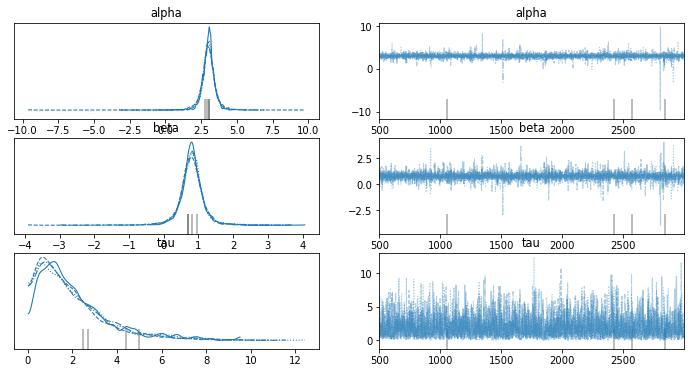

In [7]:
az.plot_trace(trace_burned)
plt.show()

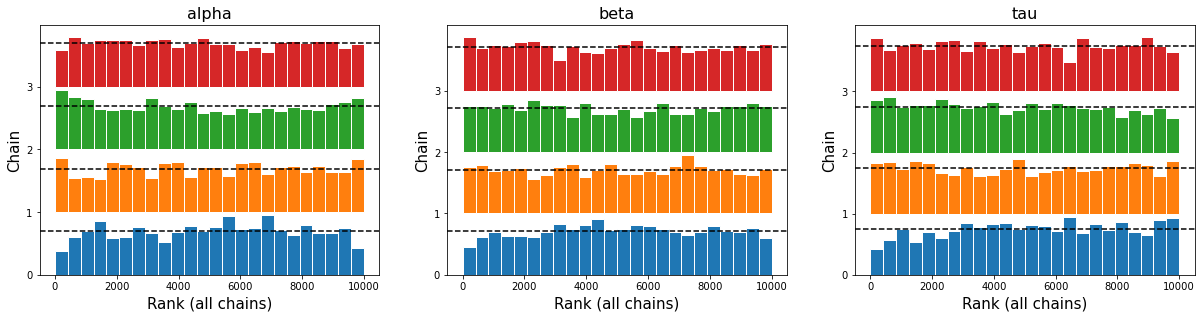

In [8]:
az.plot_rank(trace_burned)
plt.show()

## Comparison with a standard regression

There are many ways to manipulate Arviz [InferenceData](https://arviz-devs.github.io/arviz/api/generated/arviz.InferenceData.html) objects to calculate statistics after sampling is complete.

In [9]:
# alpha - beta * x.bar
intercept = (
    trace_burned.posterior.alpha.mean() - trace_burned.posterior.beta.mean() * x_bar
)
intercept.values

array(0.600454)

OpenBugs results from the lecture:

|       | mean   | sd     | MC_error | val2.5pc | median | val97.5pc | start | sample |
|-------|--------|--------|----------|----------|--------|-----------|-------|--------|
| alpha | 2.995  | 0.5388 | 0.005863 | 1.947    | 3.008  | 4.015     | 1000  | 9001   |
| beta  | 0.7963 | 0.3669 | 0.003795 | 0.08055  | 0.7936 | 1.526     | 1000  | 9001   |
| tau   | 1.88   | 1.524  | 0.02414  | 0.1416   | 1.484  | 5.79      | 1000  | 9001   |


Sometimes you might want to do a sanity check with classical regression. If your Bayesian regression has non-informative priors, the results should be close.

In [10]:
reg = LinearRegression().fit(X.reshape(-1, 1), y)
# compare with intercept and beta from above
reg.intercept_, reg.coef_

(0.5999999999999996, array([0.8]))

In [11]:
%watermark -n -u -v -iv -p aesara,aeppl

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

pymc      : 4.0.1
numpy     : 1.22.4
arviz     : 0.12.1
matplotlib: 3.5.2

